<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_4_networks_with_parallel_concatenations_goog_le_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [19]:
class Inception(nn.Module):
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)

    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)

    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self, x):

    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))

    return torch.cat((p1, p2, p3, p4), dim=1)

In [20]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [21]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [22]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [23]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [24]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())

In [25]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [26]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [27]:
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 2

In [28]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [29]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [30]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [31]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):

  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print('training on', device)
  net.to(device)

  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  num_batches = len(train_iter)

  train_x = []
  test_x = []
  train_loss = []
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
      train_l = metric[0] / metric[2]
      train_a = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        train_loss.append(train_l)
        train_acc.append(train_a)
        train_x.append(epoch + (i + 1) / num_batches)
    test_acc.append(evaluate_accuracy_gpu(net, test_iter))
    test_x.append(epoch + 1)
    print(f'epoch: {(epoch + 1):f}, train loss {train_loss[-1]:.3f}, train acc {train_acc[-1]:.3f}, '
          f'test acc {test_acc[-1]:.3f}')

  print(f'train loss {train_loss[-1]:.3f}, train acc {train_acc[-1]:.3f}, '
          f'test acc {test_acc[-1]:.3f}')
  plt.plot(train_x, train_loss, 'r')
  plt.plot(train_x, train_acc, 'b')
  plt.plot(test_x, test_acc, 'g')
  plt.show()

In [32]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [33]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)
    
  def __getitem__(self, idx):
    return self.data[idx]

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

training on cuda:0
epoch: 1.000000, train loss 1.851, train acc 0.289, test acc 0.592
epoch: 2.000000, train loss 0.704, train acc 0.730, test acc 0.804
epoch: 3.000000, train loss 0.486, train acc 0.820, test acc 0.823
epoch: 4.000000, train loss 0.382, train acc 0.856, test acc 0.856
epoch: 5.000000, train loss 0.338, train acc 0.872, test acc 0.872
epoch: 6.000000, train loss 0.308, train acc 0.882, test acc 0.873
epoch: 7.000000, train loss 0.285, train acc 0.891, test acc 0.878
epoch: 8.000000, train loss 0.286, train acc 0.893, test acc 0.891
epoch: 9.000000, train loss 0.252, train acc 0.906, test acc 0.891
epoch: 10.000000, train loss 0.241, train acc 0.908, test acc 0.890
train loss 0.241, train acc 0.908, test acc 0.890


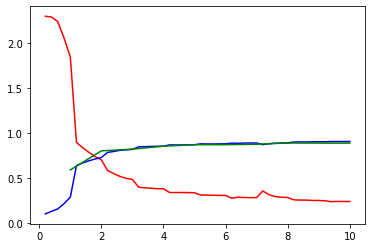

In [34]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())